## Librerias

In [37]:
import pandas as pd
import numpy as np

from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore")

## Carga de Datos

In [38]:
data = pd.read_csv("btcusd_1-min_data.csv")
data.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944800 entries, 0 to 6944799
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   datetime   object 
dtypes: float64(6), object(1)
memory usage: 370.9+ MB


## Preprocesamiento

In [40]:
data.columns = data.columns.str.lower()
print(data.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'datetime'], dtype='object')


No se encuentran observaciones duplicadas

In [41]:
data.duplicated().value_counts()

False    6944800
Name: count, dtype: int64

Existen fechas en el campo datetime con valores nulos.

In [42]:
data["datetime"].isna().value_counts()

datetime
False    6782280
True      162520
Name: count, dtype: int64

Se calculara el campo datetime a partir del campo timestamp

In [43]:
data["datetime"] = pd.to_datetime(data["timestamp"], unit="s", utc=True)
data.head()

,timestamp,open,high,low,close,volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [44]:
start_date = data["datetime"].min()
end_date = data["datetime"].max()
print(f"Fecha: {start_date} - {end_date}")

Fecha: 2012-01-01 10:01:00+00:00 - 2025-03-17 00:00:00+00:00


No se encuentran fechas faltantes

In [45]:
date_range = pd.date_range(start=start_date, end=end_date, freq="B")
missing_dates = date_range.difference(data["datetime"])
len_missing_dates = len(missing_dates)
pct_missing_dates = len_missing_dates/len(data)*100
print(f"Fechas faltantes: {len_missing_dates} - {pct_missing_dates:.2f}%")

Fechas faltantes: 0 - 0.00%


In [46]:
df_missing_dates = pd.DataFrame({"datetime": missing_dates})
df_missing_dates["datetime"] = pd.to_datetime(df_missing_dates["datetime"])
df_missing_dates["day"] = df_missing_dates["datetime"].dt.day_name()
df_missing_dates["day"].value_counts()

Series([], Name: count, dtype: int64)

El conjunto de datos contiene el costo del bitcoin minuto a minuto. Se planea enfocar el proyecto en precios semanales para disminuir la volatilidad.

In [47]:
data["date"] = data["datetime"].dt.date  
daily_data = data.groupby("date").agg({
    "open": "first",    # Primer precio de apertura del día
    "high": "max",      # Precio más alto del día
    "low": "min",       # Precio más bajo del día
    "close": "last",    # Último precio de cierre del día
    "volume": "sum"     # Volumen total del día
}).reset_index()

In [48]:
daily_data.head()

,date,open,high,low,close,volume
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742


Obtener los datos desde 01/2020 - 12/2024

In [49]:
daily_data["date"] = pd.to_datetime(daily_data["date"])
current_year = daily_data["date"].dt.year.max()
daily_data = daily_data[
    (daily_data["date"].dt.year >= (current_year - 5)) 
    & (daily_data["date"].dt.year < 2025) 
]

In [50]:
daily_data = daily_data.set_index("date")
weekly_data = daily_data.resample("W").agg({
    "open": "first",
    "high": "max", 
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index()
daily_data = daily_data.reset_index()

In [51]:
weekly_data.head()

,date,open,high,low,close,volume
0,2020-01-05,7145.05,7495.00,6853.53,7430.83,18877.685383
1,2020-01-12,7431.63,8463.57,7310.00,8113.39,51732.118034
2,2020-01-19,8114.82,9188.10,8039.00,8640.60,56161.696306
3,2020-01-26,8641.38,8792.98,8212.90,8553.43,36543.094005
4,2020-02-02,8553.43,9570.00,8519.63,9437.47,43689.685350


In [54]:
weekly_data.describe().round(2).to_clipboard()

In [16]:
from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = weekly_data["date"],
    y = weekly_data["close"].astype(float),
    mode = "lines",
    name = "Close"
)

layout = dict(
    title="Precio Semanal del Bitcoin",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=12,
                     label="1y",
                     step="month",
                     stepmode="backward"),
                dict(count=36,
                     label="3y",
                     step="month",
                     stepmode="backward"),
                dict(count=60,
                     label="5y",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type="date"
    ),
    template="seaborn"
)
plots = [trace1]
fig = dict(data=plots, layout=layout)
iplot(fig, filename = "Precio Semanal del Bitcoin")

In [34]:
def plot_yearly_price_overlay_with_global_trend(data, date_col="date", price_col="close"):
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.loc[data[date_col].dt.year < 2025]
    
    data["Year"] = data[date_col].dt.year
    data["DayOfYear"] = data[date_col].dt.dayofyear

    full_days = pd.DataFrame({"DayOfYear": range(1, 367)})
    traces = []

    for year in sorted(data["Year"].unique()):
        yearly_data = data[data["Year"] == year][["DayOfYear", price_col]].copy()
        yearly_data = full_days.merge(yearly_data, on="DayOfYear", how="left")
        yearly_data[price_col] = yearly_data[price_col].interpolate()
        
        trace = go.Scatter(
            x=yearly_data["DayOfYear"],
            y=yearly_data[price_col],
            mode="lines",
            name=str(year),
            line=dict(width=1.5)
        )
        traces.append(trace)

    global_trend = data.groupby("DayOfYear")[price_col].mean().reset_index()
    global_trend = full_days.merge(global_trend, on="DayOfYear", how="left")
    global_trend[price_col] = global_trend[price_col].interpolate()
    global_trend[price_col] = gaussian_filter1d(global_trend[price_col], sigma=4)
    
    trend_trace = go.Scatter(
        x=global_trend["DayOfYear"],
        y=global_trend[price_col],
        mode="lines",
        name="Tendencia General",
        line=dict(color="black", width=4, dash="dash")
    )
    traces.append(trend_trace)

    layout = dict(
        title="Comparación de Precios por Año",
        xaxis=dict(title="Día del Año", dtick=30),
        yaxis=dict(title="Precio (USD)"),
        template="seaborn"
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig, filename="Yearly Price Overlay with Global Trend")

plot_yearly_price_overlay_with_global_trend(weekly_data)


Comprobar si la variable "close" es estacionaria usando la prueba ADF

In [ ]:
weekly_data.set_index("date", inplace=True)
result = adfuller(weekly_data["close"])
print("Estadístico ADF:", result[0])
print("Valor p:", result[1])

if result[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

Estadístico ADF: -0.9561417226714982
Valor p: 0.7689227825475343
La serie no es estacionaria.


Comprobar si la serie temporal de "close" es estacional usando seasonal_decompose

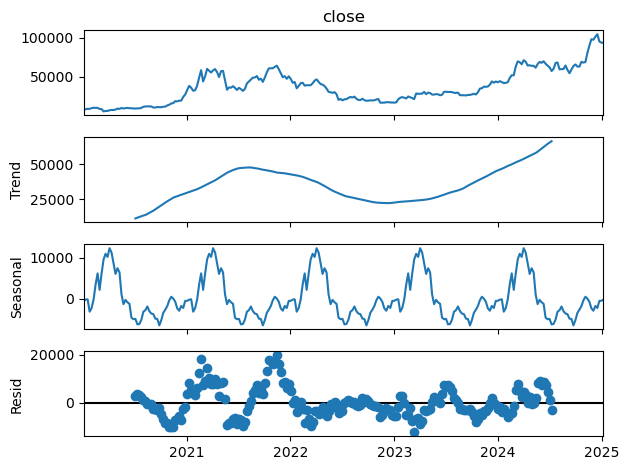

In [ ]:
result = seasonal_decompose(weekly_data["close"], model="additive", period=52)
result.plot()
plt.show()

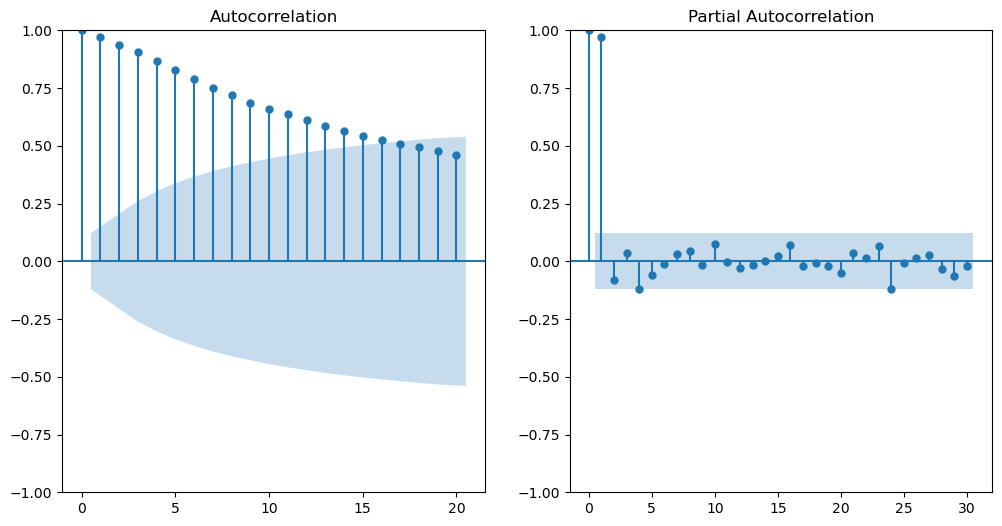

In [60]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

# ACF - Gráfico de autocorrelación
plt.subplot(121)
plot_acf(weekly_data["close"], ax=plt.gca(), lags=20)

# PACF - Gráfico de autocorrelación parcial
plt.subplot(122)
plot_pacf(weekly_data["close"], ax=plt.gca(), lags=30)

plt.show()

Variables a utilizar

In [115]:
weekly_data[['date','close']]

,date,close
0,2020-01-05,7430.83
1,2020-01-12,8113.39
2,2020-01-19,8640.60
3,2020-01-26,8553.43
4,2020-02-02,9437.47
...,...,...
257,2024-12-08,101204.00
258,2024-12-15,104427.00
259,2024-12-22,95098.00
260,2024-12-29,93557.00


In [116]:
weekly_data.set_index("date", inplace=True)

## Modelos

Modelo AR (AutoReg) para la serie temporal "close"

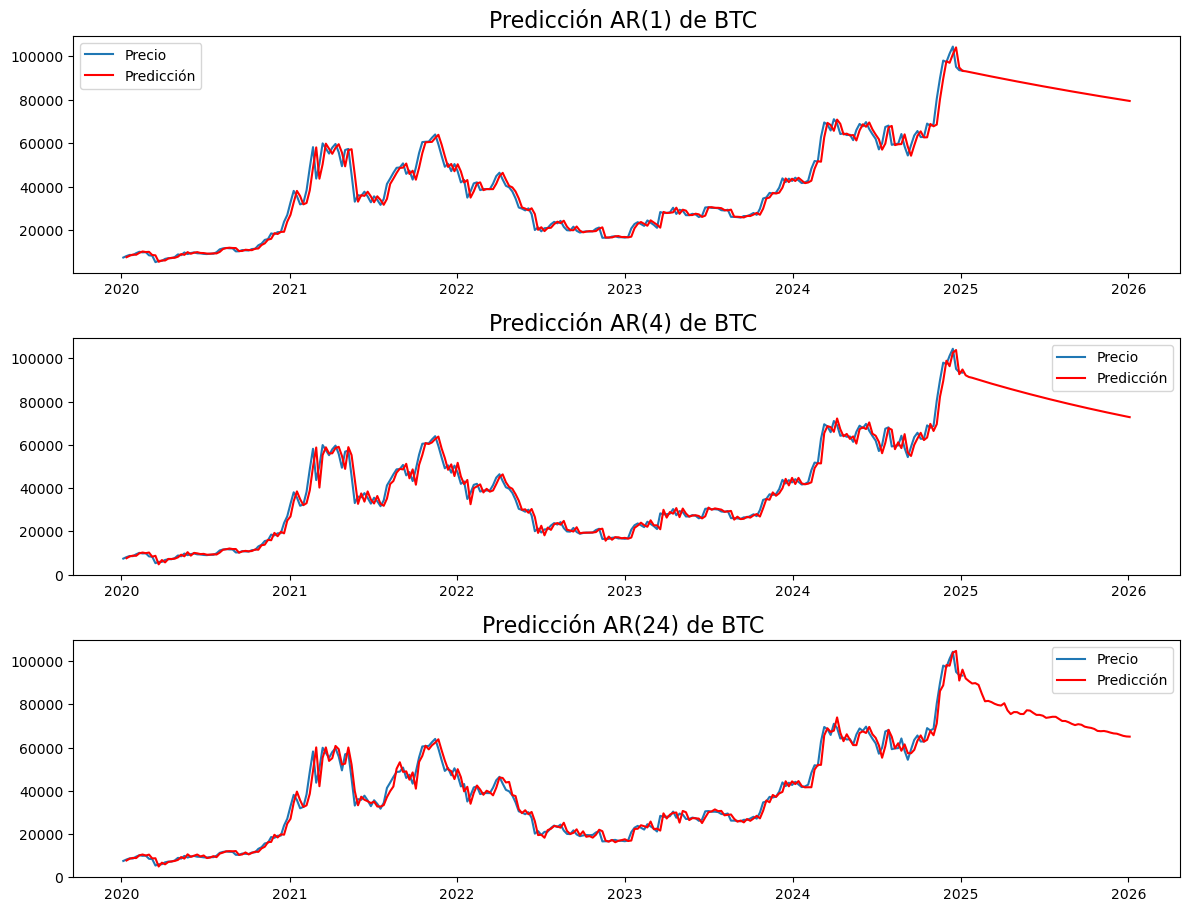

In [120]:
plt.figure(figsize=(12,12))

p = [1, 4, 24]

model_orders = p
fitted_model_dict = {}
pred_ar = {}

for idx, order in enumerate(model_orders):
    model_ar = ARIMA(weekly_data["close"], order=(order,0,0))
    model_ar_fitted = model_ar.fit()
    fitted_model_dict[order] = model_ar_fitted
    pred_ar[order] = model_ar_fitted.predict(start=1, end=len(weekly_data)+51, dynamic=False)
    plt.subplot(4,1,idx+1)
    plt.plot(weekly_data["close"], label="Precio")
    plt.plot(pred_ar[order], label="Predicción", color="red")
    plt.title("Predicción AR(%s) de BTC "%order, fontsize=16)
    plt.legend()

plt.tight_layout()

In [121]:
import pandas as pd

def aic_bic_comparison(model_orders, fitted_model_dict):
    aic_values = []
    bic_values = []
    
    for order in model_orders:
        aic_values.append((order, fitted_model_dict[order].aic))
        bic_values.append((order, fitted_model_dict[order].bic))

    comparison_df = pd.DataFrame({
        'Order': [x[0] for x in aic_values],
        'AIC': [x[1] for x in aic_values],
        'BIC': [x[1] for x in bic_values]
    })
    
    return comparison_df.round(1).sort_values(by=["AIC","BIC"]).reset_index(drop=True)


aic_bic_comparison(model_orders, fitted_model_dict)

,Order,AIC,BIC
0,4,5013.9,5035.4
1,24,5019.2,5112.0
2,1,5024.5,5035.2


In [122]:
#Based on AIC criteria, pick AR(4)
pred_ar = pred_ar[4]

MA (Moving Average)

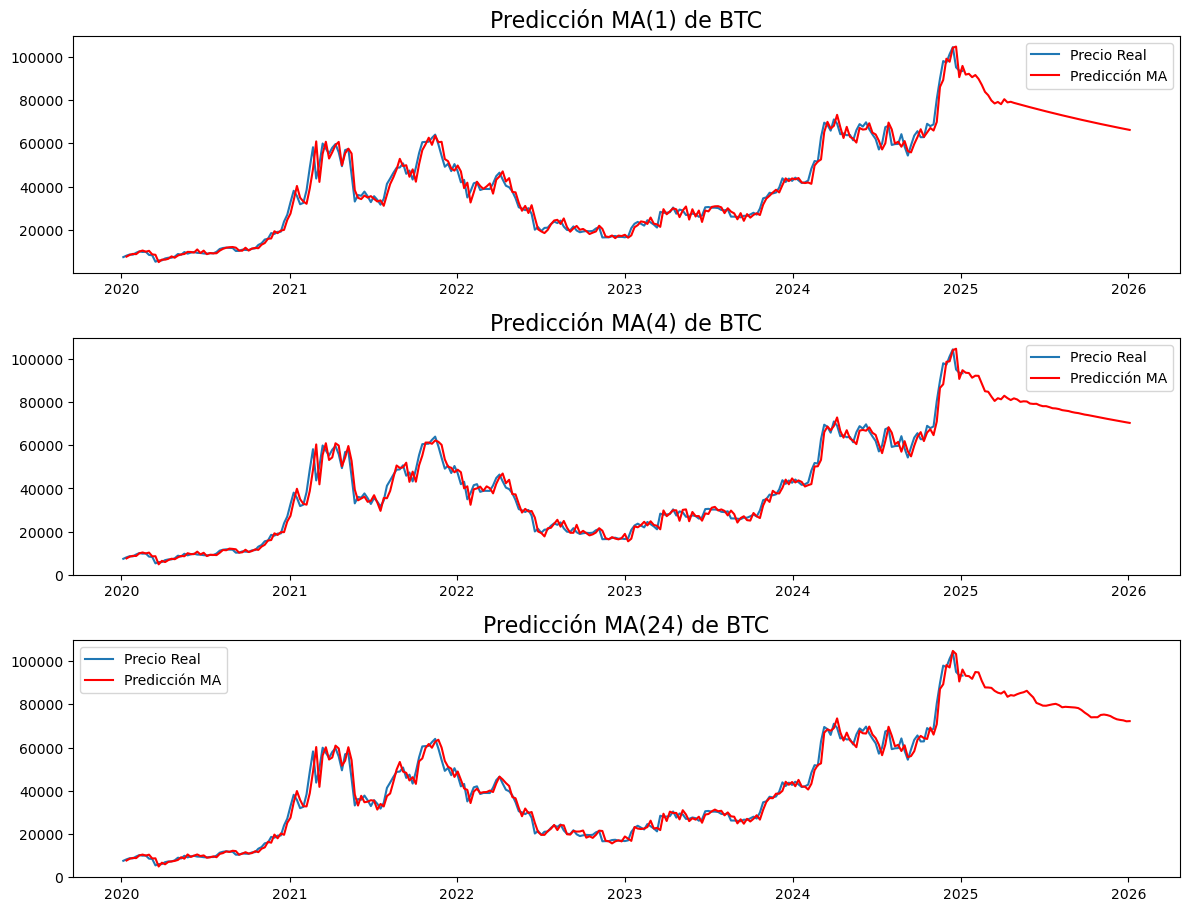

In [124]:
plt.figure(figsize=(12,12))

p = [1, 4, 24]
q = 16
model_orders = p
fitted_model_dict = {}
pred_ma = {}

for idx, order in enumerate(model_orders):
    model_ma = ARIMA(weekly_data["close"], order=(order, 0, q))
    model_ma_fitted = model_ma.fit()
    fitted_model_dict[order] = model_ma_fitted
    pred_ma[order] = model_ma_fitted.predict(start=1, end=len(weekly_data)+51, dynamic=False)

    plt.subplot(4, 1, idx+1)
    plt.plot(weekly_data["close"], label="Precio Real")
    plt.plot(pred_ma[order], label="Predicción MA", color="red")
    plt.title(f"Predicción MA({order}) de BTC", fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

In [125]:
aic_bic_comparison(model_orders, fitted_model_dict)

,Order,AIC,BIC
0,4,5014.9,5093.4
1,1,5016.5,5084.3
2,24,5032.1,5182.0


In [126]:
#Based on BIC criteria, pick MA(1, 0, 16)
pred_ma = pred_ma[1]

Modelo ARIMA

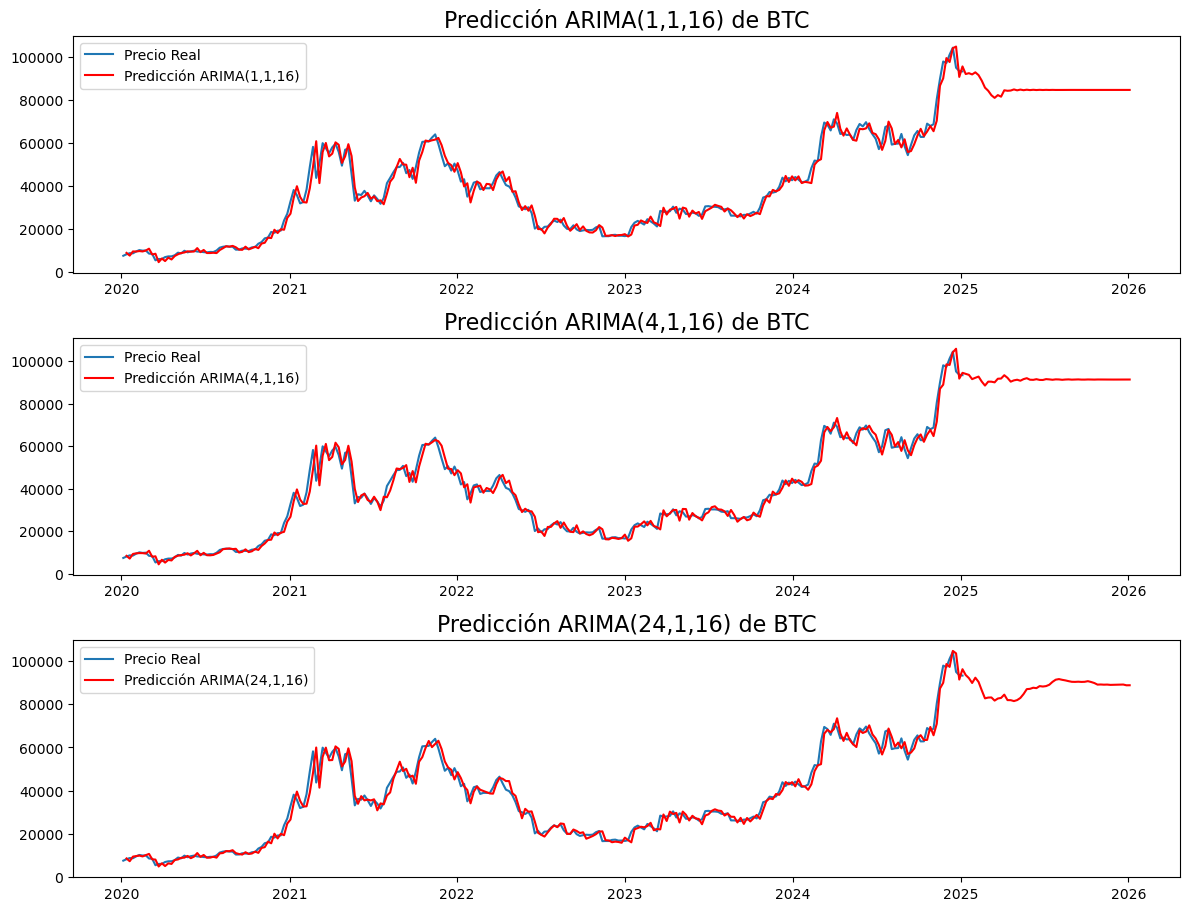

In [127]:
plt.figure(figsize=(12, 12))

model_orders = [(1, 16), (4, 16), (24, 16)]
fitted_model_dict = {}
pred_arima = {}

for idx, (x, y) in enumerate(model_orders):
    model_arima = ARIMA(weekly_data["close"], order=(x, 1, y))
    results = model_arima.fit()
    fitted_model_dict[(x, y)] = results
    pred_arima[(x, y)] = results.predict(start=1, end=len(weekly_data) + 51, dynamic=False)
    
    plt.subplot(4, 1, idx+1)
    plt.plot(weekly_data["close"], label="Precio Real")
    plt.plot(pred_arima[(x, y)], label=f"Predicción ARIMA({x},1,{y})", color="red")
    plt.title(f"Predicción ARIMA({x},1,{y}) de BTC", fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()


In [128]:
aic_bic_comparison(model_orders, fitted_model_dict)

,Order,AIC,BIC
0,"(1, 16)",4985.9,5050.1
1,"(4, 16)",4989.4,5064.3
2,"(24, 16)",5011.2,5157.3


In [129]:
#Based on AIC criteria, pick ARIMA(1, 0, 16)
pred_arima = pred_arima[(1, 16)]

Modelo SARIMA (Seasonal ARIMA)

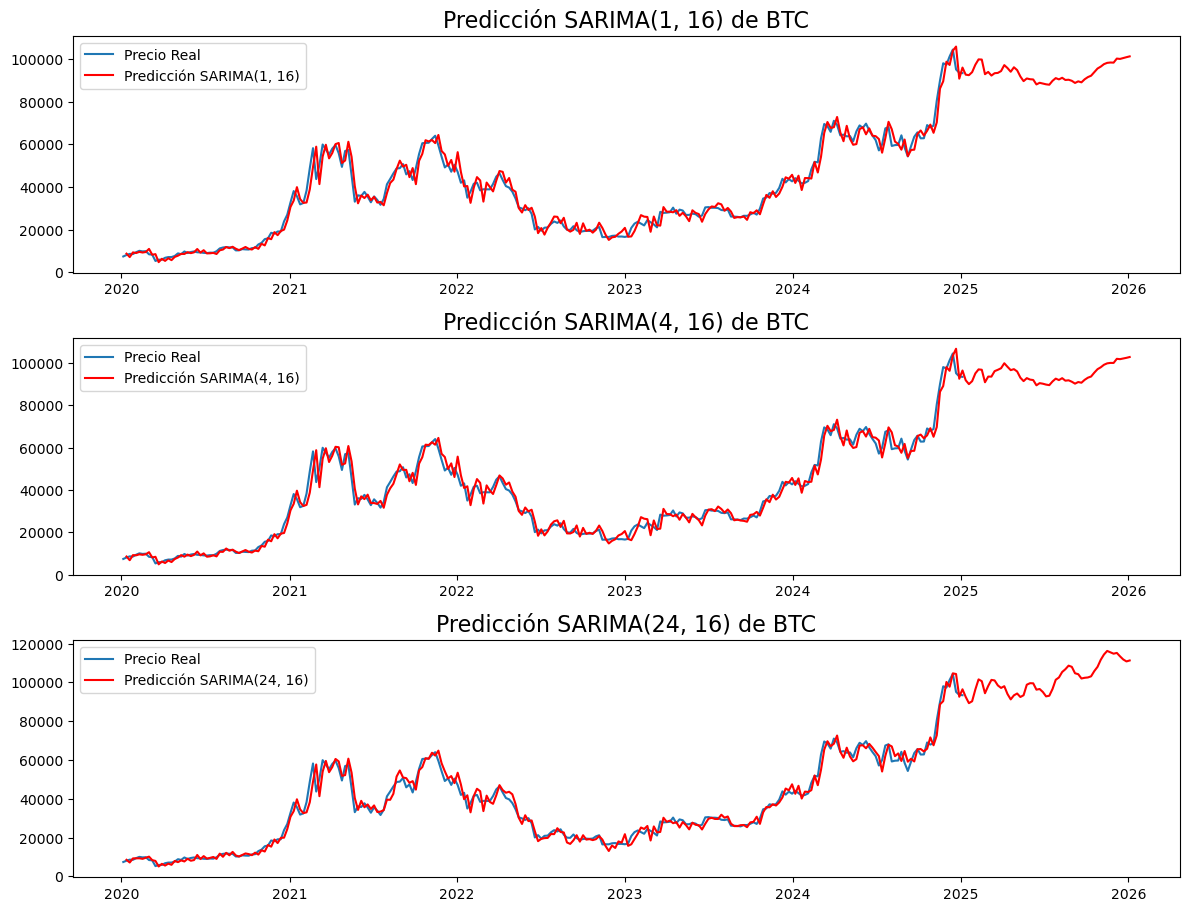

In [130]:
plt.figure(figsize=(12,12))

model_orders = [(1, 16), (4, 16), (24, 16)]
fitted_model_dict = {}
pred_sarima = {}

for idx, (x, y) in enumerate(model_orders):
    model_sarima = SARIMAX(weekly_data["close"], 
                           order=(x, 1, y),
                           seasonal_order=(1, 1, 1, 52))
    
    results = model_sarima.fit()
    fitted_model_dict[(x, y)] = results
    pred_sarima[(x, y)] = results.predict(start=1, end=len(weekly_data) + 51, dynamic=False)

    plt.subplot(4, 1, idx+1)
    plt.plot(weekly_data["close"], label="Precio Real")
    plt.plot(pred_sarima[(x, y)], label=f"Predicción SARIMA({x}, {y})", color="red")
    plt.title(f"Predicción SARIMA({x}, {y}) de BTC", fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

In [131]:
aic_bic_comparison(model_orders, fitted_model_dict)

,Order,AIC,BIC
0,"(1, 16)",4068.7,4135.5
1,"(4, 16)",4072.7,4149.6
2,"(24, 16)",4088.4,4232.1


In [132]:
#Based on AIC criteria, pick ARMA(1, 0, 16)
pred_sarima = pred_sarima[(1, 16)]

## Evaluación

In [133]:
def evaluate_model(true_values, predictions):
    rmse = sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mad = np.mean(np.abs(true_values - predictions))
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    r2 = r2_score(true_values, predictions)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAD": mad,
        "MAPE (%)": mape,
        "R²": r2
    }

def get_evaluations(true_values, predictions_dict, model_names):
    evaluations = []

    for model_name in model_names:
        metrics = evaluate_model(true_values, predictions_dict[model_name])
        evaluations.append({"Modelo": model_name, **metrics})

    evaluation_df = pd.DataFrame(evaluations)

    return evaluation_df.round(2)

In [134]:
predictions_dict = {
    "AR": pred_ar[:261],
    "MA": pred_ma[:261],
    "ARIMA": pred_arima[:261],
    "SARIMA": pred_sarima[:261]
}
model_names = ["AR", "MA", "ARIMA", "SARIMA"]
evaluation_df = get_evaluations(weekly_data["close"][1:], predictions_dict, model_names)
evaluation_df.head()

,Modelo,RMSE,MAE,MAD,MAPE (%),R²
0,AR,3355.17,2293.55,2293.55,6.60,0.98
1,MA,3193.09,2216.64,2216.64,6.50,0.98
2,ARIMA,3165.93,2212.26,2212.26,6.71,0.98
3,SARIMA,3360.69,2464.39,2464.39,7.58,0.98


## Pronóstico

In [136]:
from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go

# weekly_data.reset_index(inplace=True)

trace1 = go.Scatter(
    x = weekly_data.index,
    y = weekly_data["close"].astype(float),
    mode = "lines",
    name = "Precio Real"
)

trace2 = go.Scatter(
    x = pred_ar.index,
    y = pred_ar.astype(float),
    mode = "lines",
    name = "Modelo AR"
)

trace3 = go.Scatter(
    x = pred_ma.index,
    y = pred_ma.astype(float),
    mode = "lines",
    name = "Modelo MA"
)

trace5 = go.Scatter(
    x = pred_arima.index,
    y = pred_arima.astype(float),
    mode = "lines",
    name = "Modelo ARIMA"
)

trace6 = go.Scatter(
    x = pred_sarima.index,
    y = pred_sarima.astype(float),
    mode = "lines",
    name = "Modelo SARIMA"
)

layout = dict(
    title="Precio de Cierre del Bitcoin a lo largo del tiempo",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=12,
                     label="1y",
                     step="month",
                     stepmode="backward"),
                dict(count=36,
                     label="3y",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type="date"
    ),
    template="seaborn"
)
plots = [trace1, trace2, trace3, trace5, trace6]

fig = dict(data=plots, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")